In [1]:
import pandas as pd

In [2]:
df_raw = pd.read_excel('006__Impulse dataset.xlsx', None)

try:
    df.drop(df.index, inplace=True)
except NameError:
    pass

In [3]:
# список листов книги эксель
sheets = list(df_raw.keys())
for k, v in enumerate(sheets):
    print(k, v)

0 Основная комната – Зрители
1 QA – Зрители
2 DA – Зрители
3 Маркетинг – зрители
4 Дизайн – зрители
5 Python – зрители
6 Java – Зрители
7 Веб – зрители


In [4]:
# список нужных колонок листа
columns = ['Дата', 'Имя участника',
           'На вебинаре с', 'Досмотрел до', 'Интервалы', 'присутствия', 'Продолжительность',
           'Устройство', 'Клик по кнопке',
           'Город', 'Регион', 'Ссылка входа', 'Переход с']

mapping = {'Дата': 'date',
           'Имя участника': 'name',
           'На вебинаре с': 'webinar_from',
           'Досмотрел до': 'webinar_to',
           'Интервалы': 'interval_from',
           'присутствия': 'interval_to',
           'Продолжительность': 'duration',
           'Устройство': 'device',
           'Клик по кнопке': 'click_to',
           'Город': 'city',
           'Регион': 'region',
           'Ссылка входа': 'entrance_link',
           'Переход с': 'source_link'}

In [6]:
def dataframe_processing(_df_raw_,
                         _sheet_index_,
                         _columns_):
    cdf = pd.DataFrame(_df_raw_[sheets[_sheet_index_]][_columns_])

    cdf = cdf.rename(columns=mapping)

    import hashlib
    import numpy as np

    cdf['hash'] = np.nan

    for index, row in cdf.iterrows():
        if not pd.isnull(row['name']):
            row_string = ''.join(str(value) for value in row.values)
            cdf.at[index, 'hash'] = hashlib.sha256(row_string.encode('utf-8')).hexdigest()[:32]

    cdf.loc[cdf['name'].notnull(), cdf.columns != 'name'] = \
        cdf.loc[cdf['name'].notnull(), cdf.columns != 'name'].fillna("__EMPTY__")

    cdf = cdf.ffill(axis=0)

    cdf['click_to'] = cdf['click_to'].str.split(', ')
    cdf = cdf.explode('click_to')

    cdf = cdf[cdf['webinar_to'] != "__EMPTY__"].dropna()

    cdf[['Button_Name', 'Button_Time']] = cdf['click_to'].str.split(' в ', expand=True)

    cdf = cdf.replace({'__EMPTY__': '', None: ''})

    cdf['date'] = pd.to_datetime(cdf['date'])

    try:
        cdf['webinar_from'] = pd.to_datetime(cdf['webinar_from'], format='%H:%M').dt.time
        cdf['webinar_to'] = pd.to_datetime(cdf['webinar_to'], format='%H:%M').dt.time
    except ValueError:
        cdf['webinar_from'] = pd.to_datetime(cdf['webinar_from'], format='%H:%M:%S').dt.time
        cdf['webinar_to'] = pd.to_datetime(cdf['webinar_to'], format='%H:%M:%S').dt.time

    cdf['interval_from'] = pd.to_datetime(cdf['interval_from'], format='%H:%M:%S').dt.time
    cdf['interval_to'] = pd.to_datetime(cdf['interval_to'], format='%H:%M:%S').dt.time

    from datetime import datetime

    cdf['Button_Time'] = cdf['Button_Time'].apply(
        lambda x: datetime.strptime(str(x), '%H:%M').time() if x != '' else '')

    return cdf

In [72]:
current = dataframe_processing(df_raw, 0, columns)
current

,date,name,webinar_from,webinar_to,interval_from,interval_to,duration,device,click_to,city,region,entrance_link,source_link,hash,Button_Name,Button_Time
0,2023-01-14 11:56:00,Коротаев Павел,11:56:00,12:35:00,11:56:57,12:35:42,38.750000,ПК,«Python-разработчик» в 12:35,Липецк,Липецкая область,https://start.bizon365.ru/room/81268/impulse_g...,https://www.google.com/,85d625a5e8532ca50445b9c942cb4714,«Python-разработчик»,12:35:00
1,2023-01-14 11:56:00,Роман Орлов,11:56:00,15:59:00,11:56:57,15:59:28,242.516667,ПК,,Москва,Москва,https://start.bizon365.ru/room/81268/impulse_g...,,ccf483404af198dba6fca159ad30d89d,,
2,2023-01-14 11:56:00,Борисыч,11:56:00,15:58:00,11:56:57,12:45:42,48.750000,моб,,Москва,Москва,https://start.bizon365.ru/room/81268/impulse_g...,,219062b0200f6d2c9e40884e5424ce3f,,
3,2023-01-14 11:56:00,Борисыч,11:56:00,15:58:00,12:47:52,12:47:57,0.083333,моб,,Москва,Москва,https://start.bizon365.ru/room/81268/impulse_g...,,219062b0200f6d2c9e40884e5424ce3f,,
4,2023-01-14 11:56:00,Борисыч,11:56:00,15:58:00,12:50:47,12:50:52,0.083333,моб,,Москва,Москва,https://start.bizon365.ru/room/81268/impulse_g...,,219062b0200f6d2c9e40884e5424ce3f,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5496,2023-01-14 11:56:00,Анатолий+,15:50:00,15:52:00,15:50:48,15:52:23,1.583333,ПК,,Набережные Челны,Татарстан,https://start.bizon365.ru/room/81268/impulse_g...,https://click.mail.ru/,9dc01785eddbed990b3ed2a553746ae3,,
5497,2023-01-14 11:56:00,Дарья+,15:51:00,15:54:00,15:51:18,15:54:03,2.750000,моб,,Саратов,Саратовская область,https://start.bizon365.ru/room/81268/impulse_g...,,9eb74523f744b14954d53e51c1cd734d,,
5498,2023-01-14 11:56:00,Alina,15:54:00,15:55:00,15:54:08,15:55:33,1.416667,моб,,Тбилиси,Тбилиси,https://start.bizon365.ru/room/81268/impulse_g...,,dd1f1dae2d9edd44ba1a4ea1b9fb4cd7,,
5499,2023-01-14 11:56:00,тест тестович,15:54:00,15:58:00,15:54:38,15:58:48,4.166667,ПК,,Батуми,Одесская область,https://start.bizon365.ru/room/81268/impulse_g...,,0c535fd9b0b8972da356f4d8a726ada5,,


In [9]:
from datetime import timedelta, datetime


def time_plus(_time_, _timedelta_):
    start = datetime(2000, 1, 1,
                     hour=_time_.hour,
                     minute=_time_.minute,
                     second=_time_.second)
    end = start + _timedelta_
    return end.time()


min_webinar = time_plus(current.webinar_from.min(), timedelta(minutes=-1))
max_webinar = time_plus(current.webinar_to.max(), timedelta(minutes=3))
webinar_range = pd.date_range(str(min_webinar), str(max_webinar), freq="1min").time

In [10]:
result = pd.DataFrame(columns=['_in_', '_out_',
                               'qa',
                               'da',
                               'marketing',
                               'design',
                               'python',
                               'java',
                               'web'],
                      index=webinar_range).reset_index()
result = result.rename(columns={'index': 'time'})

In [11]:
lag = 3

for index, row in result.iterrows():
    try:
        result.at[index, '_in_'] = current.loc[(current['interval_from'] >= webinar_range[index]) &
                                               (current['interval_from'] <= webinar_range[index + 1]) &
                                               (current['duration'] >= lag)].reset_index()['hash'].nunique()

        result.at[index, '_out_'] = current.loc[(current['interval_to'] >= webinar_range[index]) &
                                                (current['interval_to'] <= webinar_range[index + 1]) &
                                                (current['duration'] >= lag)].reset_index()['hash'].nunique()

        result.at[index, 'qa'] = current.loc[(current['Button_Time'] == webinar_range[index]) &
                                             (current['Button_Name'] == '«Инженер по тестированию»')].reset_index()[
            'hash'].nunique()  #TODO учесть диапазон времён!! Посчитать без учёта диапазона, и с учётом диапазона.

    except IndexError:
        result.at[index, '_in_'] = 0
        result.at[index, '_out_'] = 0
        result.at[index, 'qa'] = 0

result

,time,_in_,_out_,qa,da,marketing,design,python,java,web
0,11:55:00,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,11:56:00,340,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,11:57:00,58,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,11:58:00,70,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,11:59:00,79,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
243,15:58:00,0,56,0,NaN,NaN,NaN,NaN,NaN,NaN
244,15:59:00,0,215,0,NaN,NaN,NaN,NaN,NaN,NaN
245,16:00:00,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
246,16:01:00,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
# result.sketch.howto("")

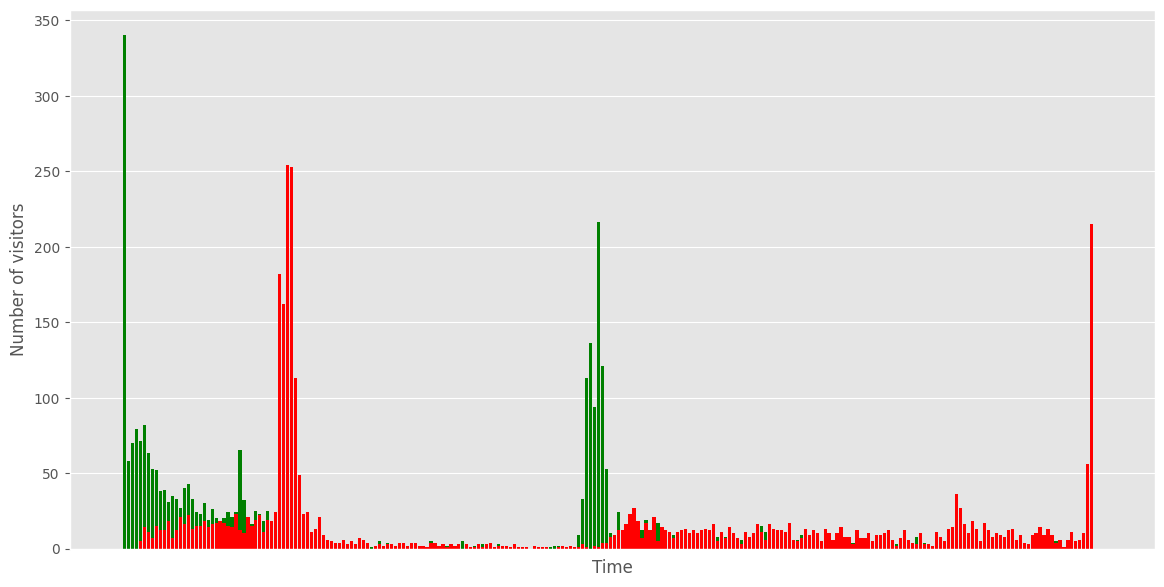

In [54]:
# import matplotlib.pyplot as plt
#
# # Create a figure and an axes
# fig, ax = plt.subplots(figsize=(14, 7))
#
# plt.style.use(style='ggplot')
# plt.xticks([])
#
# # Plot the data
# ax.bar(result['time'].astype(str), result['_in_'], label='_in_', color='green')
# ax.bar(result['time'].astype(str), result['_out_'], label='_out_', color='red')
#
# # Set the x-axis label
# ax.set_xlabel('Time')
#
# # Set the y-axis label
# ax.set_ylabel('Number of visitors')
#
# # # Add a legend
# # ax.legend()
#
# # Show the plot
# plt.show()
